In [42]:
import numpy as np
import pandas as pd
import pickle
import os
from imutils import paths
import cv2
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix ,confusion_matrix, precision_score, recall_score, f1_score
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.model_selection import learning_curve

### Getting Data

In [2]:
df = pd.read_csv("data/driver_imgs_list.csv")
classes = df.classname.unique()

In [11]:
dic = {}
j=0
for i in classes:
    dic[i]=j
    j=j+1

In [12]:
def get_data(train_path):
    X=[]
    Y=[]
    for label in classes:
        path = os.path.join(train_path , label)
        for img in os.listdir(path):
            img = cv2.imread(os.path.join(path,img))
            new_img = cv2.resize(img, (64, 128))
            X.append(new_img)
            Y.append(dic[label])
    X=np.array(X)
    Y=np.array(Y)
    return X, Y

In [13]:
train_path="data/imgs/train"
X, Y = get_data(train_path)
print(X.shape)
print(Y.shape)

(22424, 128, 64, 3)
(22424,)


In [8]:
#saving the data
# np.save("savedData/TrainingData_X",X)
# np.save("savedData/TargetData_Y",Y)

In [2]:
#loading the data

# X = np.load("savedData/TrainingData.npy")
# Y = np.load("savedData/TargetData.npy")

In [14]:
#splitting the data
X_train,x_test,Y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
X_test,X_val,Y_test,Y_val = train_test_split(x_test,y_test, test_size=0.1, random_state=1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(15696, 128, 64, 3)
(15696,)
(6055, 128, 64, 3)
(6055,)
(673, 128, 64, 3)
(673,)


## Hog Feature Extraction

In [15]:
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2',
                        orientations=9,
                        pixels_per_cell=(8, 8), 
                        cells_per_block=(3, 3),
                        multichannel  = True) 
                        for img in images])
    return result

In [16]:
hog_train = get_hog(X_train, name='hog_train', save=True)
hog_val = get_hog(X_val, name='hog_val', save=True)
print(hog_train.shape)
print(Y_train.shape)
print(hog_val.shape)
print(Y_val.shape)

c:\Users\hites\miniconda3\envs\d_driver\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  import sys


(15696, 6804)
(15696,)
(673, 6804)
(673,)


In [27]:
# data will be saved in folder savedData
# np.save("savedData/HOG_Training Data",hog_train)
# np.save("savedData/HOG_ Validation Data",hog_val)

In [28]:
# hog_train = np.load("savedData/HOG_Training Data.npy")
# hog_val = np.load("savedData/HOG_ Validation Data.npy")

## Normalization

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(hog_train)
norm_hog_train = min_max_scaler.transform(hog_train)
norm_hog_val = min_max_scaler.transform(hog_val)
print(norm_hog_train.shape)
print(norm_hog_val.shape)

(15696, 6804)
(673, 6804)


In [21]:
with open('norm_dump.pkl', 'wb') as pickle_file:
        pickle.dump(min_max_scaler, pickle_file)

## PCA

In [22]:
pca=PCA(n_components=200)
pca.fit(norm_hog_train)
pca_norm_hog_train = pca.transform(norm_hog_train)
pca_norm_hog_val = pca.transform(norm_hog_val)
print(pca_norm_hog_train.shape)
print(pca_norm_hog_val.shape)

(15696, 200)
(673, 200)


In [23]:
with open('pca_dump.pkl', 'wb') as pickle_file:
        pickle.dump(pca, pickle_file)

In [1]:
# pca_reload = pickle.load(open("pca_dump.pkl",'rb'))

In [19]:
# pca_norm_hog_train = pca_reload.transform(norm_hog_train)
# pca_norm_hog_val = pca_reload.transform(norm_hog_val)

# AHP WEIGHTS

In [24]:
def get_weights(sample):
    d_matrix = cosine_distances(sample)
    np.fill_diagonal(d_matrix, 1)
    sum_vals = np.sum(d_matrix, axis=0)
    d_updated = d_matrix/sum_vals
    weights = np.sum(d_updated, axis=1)

    return weights


In [25]:
weights = get_weights(pca_norm_hog_train)
# np.save("savedData/weights",weights) #saving the weights

## Train Model without AHP

In [26]:
model = SVC(kernel='linear')
model.fit(pca_norm_hog_train, Y_train)
accPCA = model.score(pca_norm_hog_val,Y_val)
trainAcc = model.score(pca_norm_hog_train,Y_train)

In [27]:
print("Accuracy on Training Set: ",round(trainAcc,5)*100,"%")
print("Accuracy on Validation: ",round(accPCA,5)*100,"%")

Accuracy on Training Set:  99.79599999999999 %
Accuracy on Validation:  96.88 %


## Train Model with AHP

In [28]:
model_ahp = SVC(kernel='linear')
model_ahp.fit(pca_norm_hog_train, Y_train,weights)
accPCA = model_ahp.score(pca_norm_hog_val,Y_val)
trainAcc = model_ahp.score(pca_norm_hog_train,Y_train)

In [29]:
print("Accuracy on Training Set: ",round(trainAcc,5)*100,"%")
print("Accuracy on Validation: ",round(accPCA,5)*100,"%")

Accuracy on Training Set:  99.802 %
Accuracy on Validation:  96.88 %


# Testing

In [30]:
hog_test= get_hog(X_test, name='hog_test', save=True)
norm_hog_test = min_max_scaler.transform(hog_test)
pca_norm_hog_test = pca.transform(norm_hog_test)
testingAcc_ahp = model_ahp.score(pca_norm_hog_test,Y_test)
testingAcc = model.score(pca_norm_hog_test,Y_test)

c:\Users\hites\miniconda3\envs\d_driver\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  import sys


In [31]:
print("Accuracy on testset with AHP: ",round(testingAcc_ahp,6)*100,"%")
print("Accuracy on testset without AHP: ",round(testingAcc,6)*100,"%")

Accuracy on testset with AHP:  97.5557 %
Accuracy on testset without AHP:  97.5557 %


In [32]:
with open('model_pca_dump.pkl', 'wb') as pickle_file:
        pickle.dump(model, pickle_file)
with open('model_ahp_dump.pkl', 'wb') as pickle_file:
        pickle.dump(model_ahp, pickle_file)

# Results

In [48]:
Y_pred = model_ahp.predict(pca_norm_hog_test)

In [49]:
train_size, train_score, test_score = learning_curve(model_ahp,pca_norm_hog_test,Y_test,cv=5, n_jobs=4,train_sizes=np.linspace(0.01,1,10))
train_mean = np.mean(train_score,axis=1)
test_mean = np.mean(test_score,axis=1)

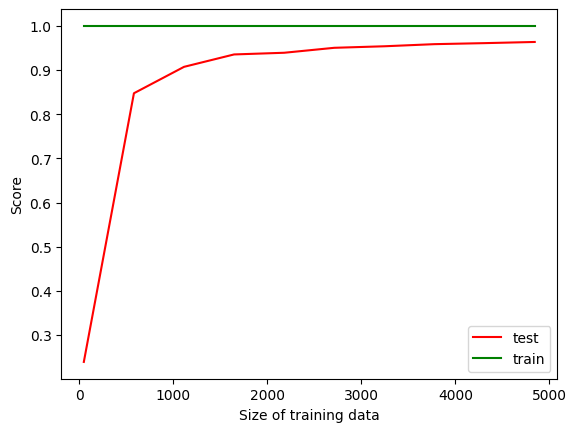

In [50]:
plt.plot(train_size,test_mean,color='r',label="test")
plt.plot(train_size,train_mean,color='g',label="train")

plt.xlabel("Size of training data")
plt.ylabel("Score")
plt.legend()
plt.show()

In [51]:
precisionRF = precision_score(Y_test,Y_pred,average="macro")
recallRF = recall_score(Y_test,Y_pred,average="macro")
fScoreRF = f1_score(Y_test,Y_pred,average="macro")

In [52]:
print("Precsion: ",round(precisionRF*100,2),"%")
print("Recall: ",round(recallRF*100,2),"%")
print("F Score: ",round(fScoreRF*100,2),"%")

Precsion:  97.59 %
Recall:  97.46 %
F Score:  97.51 %


c:\Users\hites\miniconda3\envs\d_driver\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


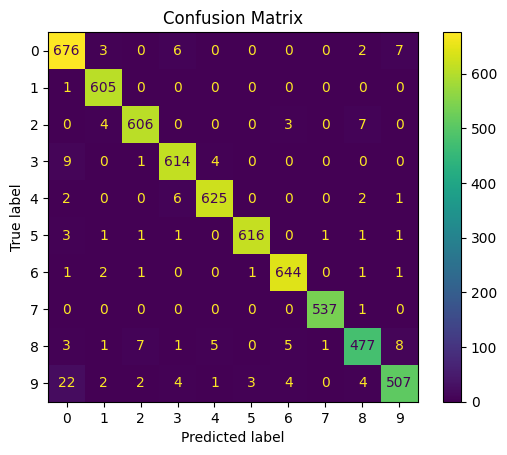

In [53]:
plot_confusion_matrix(model_ahp, pca_norm_hog_test, Y_test)
plt.title("Confusion Matrix")
plt.show()

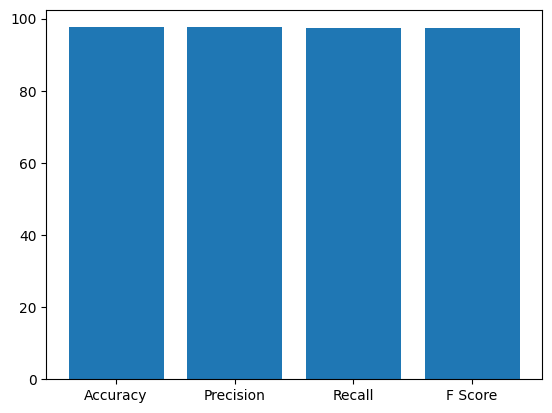

In [54]:
y_label = [testingAcc*100, precisionRF*100,recallRF*100,fScoreRF*100]
x_label = ['Accuracy','Precision','Recall','F Score']

plt.bar(x_label,y_label)
plt.show()

# Single Image Results

In [47]:
res_dictionary={
    0: "safe driving",
1: "texting - right",
2: "talking on the phone - right",
3: "texting - left",
4: "talking on the phone - left",
5: "operating the radio",
6: "drinking",
7: "reaching behind",
8: "hair and makeup",
9: "talking to passenger",
}

c:\Users\hites\miniconda3\envs\d_driver\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  import sys


Time taken to predict one image:  0.070744
operating the radio


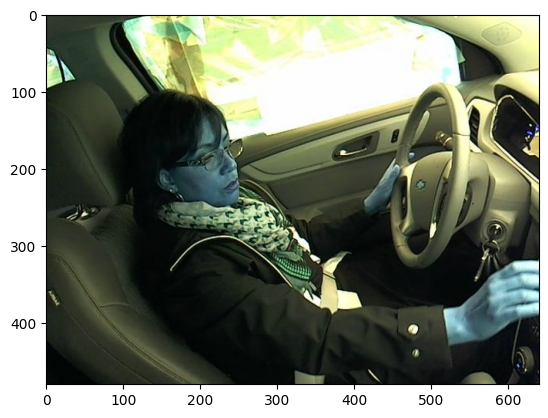

In [46]:
pca_reload = pickle.load(open("pca_dump.pkl",'rb'))
norm_reload = pickle.load(open("norm_dump.pkl",'rb'))
model = pickle.load(open("model_ahp_dump.pkl",'rb'))
path='data/imgs/test/img_1.jpg'
ti = datetime.now()
Xv=[]
img = cv2.imread(path)
new_img = cv2.resize(img, (64, 128))
Xv.append(new_img)
Xv=np.array(Xv)

plt.imshow(img)
hog_input = get_hog(Xv, name='hog_train', save=True)

norm_hog_input = norm_reload.transform(hog_input)
pca_norm_hog_train = pca_reload.transform(norm_hog_input)
driver_pred = model.predict(pca_norm_hog_train)
print("Time taken to predict one image: ",(datetime.now()-ti).total_seconds())
print(res_dictionary[(int(driver_pred[0]))])

## LDA

In [50]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# lda = LDA(n_components=9)
# lda_norm_hog_train = lda.fit_transform(norm_hog_train,Y_train)
# lda_norm_hog_val = lda.transform(norm_hog_val)

In [51]:
# print(lda_norm_hog_train.shape)
# print(lda_norm_hog_val.shape)

(15696, 9)
(3364, 9)


In [52]:
# model_lda = SVC()
# model_lda.fit(lda_norm_hog_train, Y_train)
# accLDA=model_lda.score(lda_norm_hog_val,Y_val)
# print("Accuracy on LDA: ",round(accLDA,5)*100,"%")

Accuracy on LDA:  99.614 %


In [56]:
# acctrain=model_lda.score(lda_norm_hog_train,Y_train)
# print("Accuracy on LDA: ",round(acctrain,5)*100,"%")

Accuracy on LDA:  99.994 %


In [53]:
# lda_norm_hog_test = lda.transform(norm_hog_test)
# print(lda_norm_hog_test.shape)

(3364, 9)


In [54]:
# testingAcclda = model_lda.score(lda_norm_hog_test,Y_test)

In [55]:
print("Accuracy on testset: ",round(testingAcclda,5)*100,"%")

Accuracy on testset:  99.673 %


## LDA over PCA

In [30]:
# lda_pca = LDA(n_components=9)
# lda_pca_norm_hog_train = lda_pca.fit_transform(pca_norm_hog_train,Y_train)
# lda_pca_norm_hog_val = lda_pca.transform(pca_norm_hog_val)

In [31]:
# print(lda_pca_norm_hog_train.shape)
# print(lda_pca_norm_hog_val.shape)

(16145, 9)
(1794, 9)


In [32]:
# model_lda_o_pca = SVC()
# model_lda_o_pca.fit(lda_pca_norm_hog_train, Y_train)
# acc_lda_o_pca = model_lda_o_pca.score(lda_pca_norm_hog_val,Y_val)

In [33]:
# print("Accuracy on Validation: ",round(acc_lda_o_pca,5)*100,"%")

Accuracy on Validation:  90.412 %


In [34]:
# lda_pca_norm_hog_test = lda_pca.transform(pca_norm_hog_test)
# print(lda_pca_norm_hog_test.shape)

(4485, 9)


In [35]:
# acc_lda_o_pca = model_lda_o_pca.score(lda_pca_norm_hog_test,Y_test)

In [36]:
# print("Accuracy on Validation: ",round(acc_lda_o_pca,5)*100,"%")

Accuracy on Validation:  91.327 %
